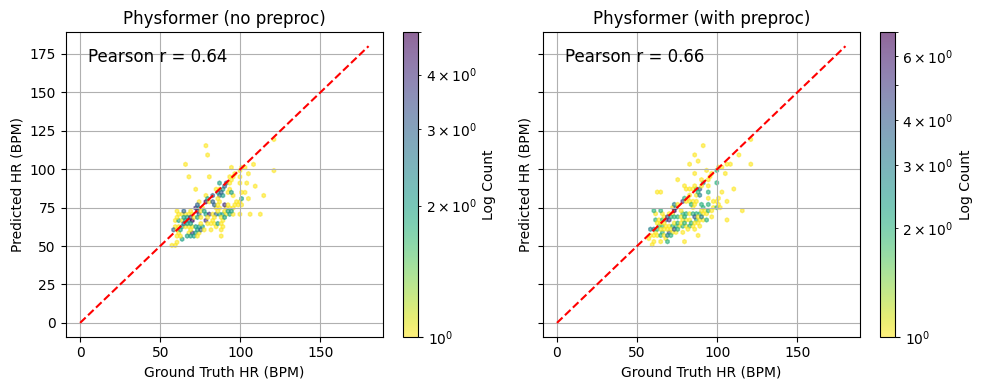

[INFO] Total number of videos processed (no preproc): 256
[INFO] Total number of videos processed (with preproc): 256


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === 1. Read two inference_log.txt files ===
log_file_path1 = "/home/siming/physformer_vipl/Inference_Physformer_VIPL/inference_log.txt"
log_file_path2 = "/home/siming/physformer_vipl/Inference_Physformer_VIPL_withpre/inference_log.txt"

with open(log_file_path1, "r") as f1:
    log_text1 = f1.read()
with open(log_file_path2, "r") as f2:
    log_text2 = f2.read()

# === 2. Extract video / HR / GT ===
pattern = r"Processing (p\d+-v\d+-source\d+).avi.*?HR: ([\d.]+) \| GT: ([\d.]+)"
matches1 = re.findall(pattern, log_text1, re.DOTALL)
matches2 = re.findall(pattern, log_text2, re.DOTALL)

df1 = pd.DataFrame(matches1, columns=["file_name", "pred_HR", "gt_HR"])
df2 = pd.DataFrame(matches2, columns=["file_name", "pred_HR", "gt_HR"])
df1["pred_HR"] = df1["pred_HR"].astype(float)
df1["gt_HR"] = df1["gt_HR"].astype(float)
df2["pred_HR"] = df2["pred_HR"].astype(float)
df2["gt_HR"] = df2["gt_HR"].astype(float)

# Optional: only keep file_names that appear in both DataFrames (alignment)
common_files = set(df1['file_name']) & set(df2['file_name'])
df1 = df1[df1['file_name'].isin(common_files)].reset_index(drop=True)
df2 = df2[df2['file_name'].isin(common_files)].reset_index(drop=True)

# # === 3. Filter out values with GT < 25 ===
# df1 = df1[df1['gt_HR'] >= 25].reset_index(drop=True)
# df2 = df2[df2['gt_HR'] >= 25].reset_index(drop=True)

# === 4. Plot Hexbin density side by side ===
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

# Plot 1: original
hb1 = axes[0].hexbin(df1['gt_HR'], df1['pred_HR'], gridsize=30, cmap='viridis_r', bins='log', alpha=0.6)
axes[0].plot([0, 180], [0, 180], 'r--', label='Ideal line')
axes[0].set_xlabel("Ground Truth HR (BPM)")
axes[0].set_ylabel("Predicted HR (BPM)")
axes[0].set_title("Physformer (no preproc)")
r1, _ = pearsonr(df1['gt_HR'], df1['pred_HR'])
axes[0].text(5, 170, f'Pearson r = {r1:.2f}', fontsize=12, color='black')
axes[0].grid(True)
cb1 = fig.colorbar(hb1, ax=axes[0], label="Log Count")

# Plot 2: with preproc
hb2 = axes[1].hexbin(df2['gt_HR'], df2['pred_HR'], gridsize=30, cmap='viridis_r', bins='log', alpha=0.6)
axes[1].plot([0, 180], [0, 180], 'r--', label='Ideal line')
axes[1].set_xlabel("Ground Truth HR (BPM)")
axes[1].set_ylabel("Predicted HR (BPM)")
axes[1].set_title("Physformer (with preproc)")
r2, _ = pearsonr(df2['gt_HR'], df2['pred_HR'])
axes[1].text(5, 170, f'Pearson r = {r2:.2f}', fontsize=12, color='black')
axes[1].grid(True)
cb2 = fig.colorbar(hb2, ax=axes[1], label="Log Count")

plt.tight_layout()
plt.show()

print(f"[INFO] Total number of videos processed (no preproc): {len(df1)}")
print(f"[INFO] Total number of videos processed (with preproc): {len(df2)}")


[INFO] MAE (no preproc): 9.29 BPM
[INFO] MAE (with preproc): 9.77 BPM


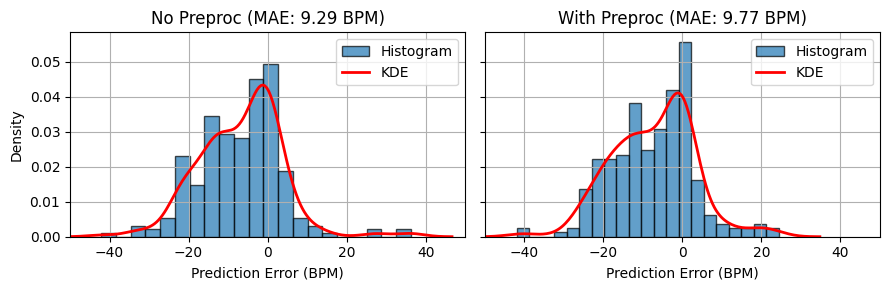

In [84]:
import numpy as np
import seaborn as sns

# Compute errors for both methods
errors1 = df1['pred_HR'] - df1['gt_HR']
errors2 = df2['pred_HR'] - df2['gt_HR']
mae1 = abs(errors1).mean()
mae2 = abs(errors2).mean()
print(f"[INFO] MAE (no preproc): {mae1:.2f} BPM")
print(f"[INFO] MAE (with preproc): {mae2:.2f} BPM")

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

# Plot 1: No Preproc
axes[0].hist(errors1, bins=21, alpha=0.7, edgecolor='k', density=True, label='Histogram')
sns.kdeplot(errors1, color='red', linewidth=2, label='KDE', ax=axes[0])
axes[0].set_xlabel('Prediction Error (BPM)')
axes[0].set_xlim(-50, 50)
axes[0].set_ylabel('Density')
axes[0].set_title(f'No Preproc (MAE: {mae1:.2f} BPM)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: With Preproc
axes[1].hist(errors2, bins=21, alpha=0.7, edgecolor='k', density=True, label='Histogram')
sns.kdeplot(errors2, color='red', linewidth=2, label='KDE', ax=axes[1])
axes[1].set_xlabel('Prediction Error (BPM)')
axes[1].set_xlim(-50, 50)
axes[1].set_ylabel('Density')
axes[1].set_title(f'With Preproc (MAE: {mae2:.2f} BPM)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


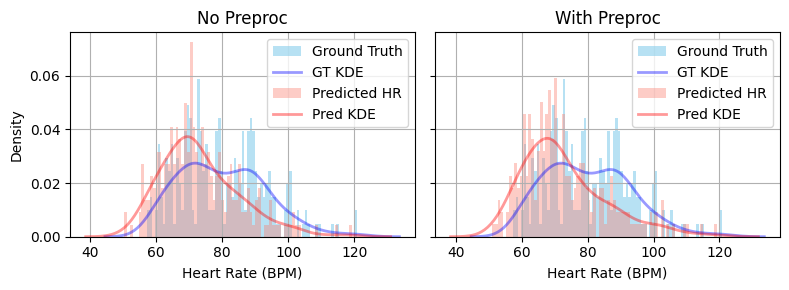

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)

# Plot for df1 (No Preproc)
axes[0].hist(df1['gt_HR'], bins=80, alpha=0.6, label='Ground Truth', color='skyblue', density=True)
sns.kdeplot(df1['gt_HR'], color='blue', linewidth=2, label='GT KDE', alpha=0.4, ax=axes[0])
axes[0].hist(df1['pred_HR'], bins=80, alpha=0.4, label='Predicted HR', color='salmon', density=True)
sns.kdeplot(df1['pred_HR'], color='red', linewidth=2, label='Pred KDE', alpha=0.4, ax=axes[0])
axes[0].set_xlabel('Heart Rate (BPM)')
axes[0].set_ylabel('Density')
axes[0].set_title('No Preproc')
axes[0].legend()
axes[0].grid(True)

# Plot for df2 (With Preproc)
axes[1].hist(df2['gt_HR'], bins=80, alpha=0.6, label='Ground Truth', color='skyblue', density=True)
sns.kdeplot(df2['gt_HR'], color='blue', linewidth=2, label='GT KDE', alpha=0.4, ax=axes[1])
axes[1].hist(df2['pred_HR'], bins=80, alpha=0.4, label='Predicted HR', color='salmon', density=True)
sns.kdeplot(df2['pred_HR'], color='red', linewidth=2, label='Pred KDE', alpha=0.4, ax=axes[1])
axes[1].set_xlabel('Heart Rate (BPM)')
axes[1].set_ylabel('Density')
axes[1].set_title('With Preproc')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()